In [1]:
import numpy as np
import pandas as pd
import json
import re
from tqdm.notebook import tqdm
import os
from datetime import datetime
import glob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 7.2 MB/s eta 0:00:00


In [3]:
from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Mecab

## Okt, Tf-Idf 이용하여 일단 학습 시켜보기

- 전처리 : 한글 제거, 불용어 X, 1글자 초과만 남기기, 품사(명사, 형용사, 동사) 태그

### 데이터 불러오기

In [37]:
df_all = pd.read_csv('/content/df_reviews.csv', index_col=0, encoding='utf-8-sig')
df_all

,Review,Score
0,"딸기뷔페 분위기 좋은 공간, 우드 계열 실내",4
1,망고가 전혀 달지 않아요....다른 호텔 라운지에서도 먹어봤는데 여기만 망고 맛이 ...,2
2,호텔이니 비싼거 감안하고 분위기 좋다. 밥도 굳,5
3,! 물어보니 도쿄와 Spanish차이는 전자 덜 단대요. 갈때 딱 줄이 없었어요. ...,5
4,사람 많고 북적거리고 커피도 넘넘 비싸지만맛있고 직원분들도 친절하셔서한 번쯤 가볼만...,5
...,...,...
25564,갤러리와 함께 있는 넓은 공간의 카페입니다. illy 커피를 판매하는 곳입니다. 주...,4
25565,알바 ○○○ 띠꺼움 ㅋㅋㅋ,1
25566,교회랑 가까와서 자주 가는데 사장님 음식 맛 짱이고 분위기도 음악도 우리 취향이라 ...,5
25567,한달에 2~3번 가는데요.. 실망한 적이 없네요,5


In [38]:
# 중복값, 결측치 제거
df_all = df_all.drop_duplicates()
df_all = df_all.dropna()
df_all = df_all.reset_index(drop = True)

In [39]:
df_all.isnull().sum()

Review    0
Score     0
dtype: int64

In [40]:
df_all.duplicated().sum()

0

In [41]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25569 entries, 0 to 25568
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  25569 non-null  object
 1   Score   25569 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 399.6+ KB


In [42]:
df_test = pd.read_csv('/content/song_test_reviews.csv', index_col=0, encoding='utf-8-sig')
df_test

,Review,Score
0,처음 말차라떼를 마시다보니 비교대상이 없네요. 말차의 향과 맛으로 색다른 느낌의 음...,4
1,동탄 롯백에 들어온 슈퍼말차 말차맛이 진하고 많이 달지않아 말차라떼 매니아들 강추!...,5
2,"마감 시간이라 보틀로 구매 했는데, 정말 달지 않고 맛있어서 또 가고 싶네요!:) ...",5
3,초등학교 앞이라 그런지 학부모분들이 많이 오고 그래서 좀 시끄러웠지만 디저트류는 정...,5
4,우드톤의 인테리어와 편안한 분위기가 좋네요. 샌드위치 재료를 신선한 것을 사용하셔서...,5
...,...,...
644,여기 와플이 정말맛있어요! 무조건 갈매기다방가면 와플은 먹어야합니다~~,4
645,친절한 주인아주머니 다양한 메뉴와 깔끔하면서 중독성 있는 맛,4
646,55점 22.3.13. 알베로 가게- 강릉 안목해변 앞에 위치한 카페이다. [메...,4
647,3층까지있고 경치구경하기 좋게 바로 앞에 바다뷰 창가 자리는 늘 인기가 좋음 야외자...,1


In [43]:
# 중복값, 결측치 제거
df_test = df_test.drop_duplicates()
df_test = df_test.dropna()
df_test = df_test.reset_index(drop = True)

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  645 non-null    object
 1   Score   645 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ KB


#### 2진 분류 Score 1-3 : 1, 4-5 : 2 (필요 시 실행)

In [129]:
df_all.loc[df_all['Score'] > 3, 'Score_div'] = 'Positive'
df_all.loc[df_all['Score'] < 4, 'Score_div'] = 'Negative'
df_all

,Review,Score,preprocessed,Score_div
0,"딸기뷔페 분위기 좋은 공간, 우드 계열 실내",4,딸기 뷔페 분위기 좋다 공간 우드 계열 실내,Positive
1,망고가 전혀 달지 않아요....다른 호텔 라운지에서도 먹어봤는데 여기만 망고 맛이 ...,2,망고 전혀 않다 다른 호텔 라운지 먹다 보다 망고 작년 괜찮다 같다 매우 아쉽다,Negative
2,호텔이니 비싼거 감안하고 분위기 좋다. 밥도 굳,5,호텔 비싸다 감안 분위기 좋다 굳다,Positive
3,! 물어보니 도쿄와 Spanish차이는 전자 덜 단대요. 갈때 딱 줄이 없었어요. ...,5,물어보다 차이다 전자 단대 줄이다 없다 커피 예쁘다 나오다 라떼 시키다 고소하다,Positive
4,사람 많고 북적거리고 커피도 넘넘 비싸지만맛있고 직원분들도 친절하셔서한 번쯤 가볼만...,5,사람 많다 북적 거리 커피 넘다 넘다 비싸다 맛있다 직원 친절하다 서한 가보다 하다 같다,Positive
...,...,...,...,...
25239,갤러리와 함께 있는 넓은 공간의 카페입니다. illy 커피를 판매하는 곳입니다. 주...,4,갤러리 있다 넓다 공간 카페 커피 판매 하다 주차장 있다,Positive
25240,알바 ○○○ 띠꺼움 ㅋㅋㅋ,1,알바,Negative
25241,교회랑 가까와서 자주 가는데 사장님 음식 맛 짱이고 분위기도 음악도 우리 취향이라 ...,5,교회 가깝다 서다 자주 가다 사장 음식 분위기 음악 우리 취향 넘다 좋다 격주 쉬다...,Positive
25242,한달에 2~3번 가는데요.. 실망한 적이 없네요,5,가다 실망하다 없다,Positive


In [117]:
df_all['Score_div'].value_counts()

2.0    18417
1.0     6827
Name: Score_div, dtype: int64

In [ ]:
df_test.loc[df_test['Score'] > 3, 'Score_div'] = 2
df_test.loc[df_test['Score'] < 4, 'Score_div'] = 1
df_test

,Review,Score,preprocessed,Score_div
0,처음 말차라떼를 마시다보니 비교대상이 없네요. 말차의 향과 맛으로 색다른 느낌의 음...,4,처음 라떼 보다 비교 대상 없다 색다르다 느낌 음료 해보다,2.0
1,동탄 롯백에 들어온 슈퍼말차 말차맛이 진하고 많이 달지않아 말차라떼 매니아들 강추!...,5,동탄 들어오다 슈퍼 진하다 않다 라떼 매니아 강추 충분하다 흔들다 먹다 진하다 좋다,2.0
2,"마감 시간이라 보틀로 구매 했는데, 정말 달지 않고 맛있어서 또 가고 싶네요!:) ...",5,마감 시간 구매 하다 정말 않다 맛있다 가다 매장 많다 않다 아쉽다,2.0
3,초등학교 앞이라 그런지 학부모분들이 많이 오고 그래서 좀 시끄러웠지만 디저트류는 정...,5,초등학교 학부모 오다 시끄럽다 디저트 정말 맛있다,2.0
4,우드톤의 인테리어와 편안한 분위기가 좋네요. 샌드위치 재료를 신선한 것을 사용하셔서...,5,우드 인테리어 편안하다 분위기 좋다 샌드위치 재료 신선하다 사용 하다 맛있다 같다,2.0
...,...,...,...,...
637,여기 와플이 정말맛있어요! 무조건 갈매기다방가면 와플은 먹어야합니다~~,4,와플 정말 맛있다 무조건 갈매기 가면 와플 먹다,2.0
638,친절한 주인아주머니 다양한 메뉴와 깔끔하면서 중독성 있는 맛,4,친절하다 주인 아주머니 다양하다 메뉴 깔끔하다 중독 있다,2.0
639,55점 22.3.13. 알베로 가게- 강릉 안목해변 앞에 위치한 카페이다. [메...,4,알베 가게 강릉 안목 해변 위치 카페 메뉴 초코 라떼 그리다 설명 하다 기본 초코 ...,2.0
640,3층까지있고 경치구경하기 좋게 바로 앞에 바다뷰 창가 자리는 늘 인기가 좋음 야외자...,1,있다 경치 구경 하다 좋다 바로 바다 창가 자리다 인기 좋다 야외 개정 있다,1.0


In [ ]:
df_test['Score_div'].value_counts()

2.0    496
1.0    146
Name: Score_div, dtype: int64

### 불용어 텍스트

In [45]:
stopword = open('/content/stop_words.txt', 'rt').read()
stopwords = stopword.split(' ')
print(stopwords, len(stopwords))

['그저', '그렇다', '나라', '이다', '딱하다', '굿즈', '아스', '왜왜', '샌프란시스코', '개불', '도쿄', '블루', '보틀', '육천원', '거마', '여기', '싶다', '스터디', '때문', '댓글', '여자', '들여다보다', '남자', '여자', '계시다', '치다', '드립커피', '잇다', '에이', '들다', '착즙', '가세', '이드', '다크', '샹그리', '장님', '니당다', '프린트', '붙다', '트렘벌린', '도넛', '밀가루', '나서다', '감다', '녹차', '말차', '헤드셋', '마이크', '이나', '자체', '보드', '마우스', '사양', '로지텍', '일산', '라이언', '출입', '말다', '어차피', '예정', '가야', '리도', '악세다', '다방', '슈페', '아인', '한류', '북한', '개다', '인터넷', '공용', '문턱', '코코넛', '바안', '보체', '샘플러', '글라스', '칵테일', '위스키', '계단', '비상', '지큐', '조리사', '애오개', '파다', '스카', '법도', '일본인', '야하다', '고여', '정체', '나다', '쓰시', '시반', '후시', '스위스', '다임', '그게', '갈다', '만요', '장님', '여사', '친전', '읍니', '낭시', '전과', '거려', '다해', '대서', '사보다', '달구', '가계', '절기', '두다', '꾸다', '돼다', '런가', '로나', '호점층', '이드', '도리', '오잉', '오예', '프라하', '상치', '그루', '나루', '허니', '시험', '리코', '밤톨', '어어', '토일', '오시', '카이', '전당', '제스', '격인', '아메', '소담', '편이', '사람인', '아바', '머거다', '펫프렌', '리해', '놀숲', ''] 148


In [46]:
# # 불용어 사전 - 리스트로 사용
# stopwords = ['목소리']

# with open('nsmc_stopwords.txt', 'wt') as f:
#     f.write('\n'.join(stopwords))  # 리스트 -> 문자열

# # f = open('nsmc_stopwords.txt', 'wt')
# # f.write(stopwords_str)
# # f.close()

### 노이즈 제거 과정 함수화 및 새로운 열 생성

In [47]:
# 하나의 함수로 노이즈 제거 과정 정리 - Okt

def okt_preprocessing(review):
    okt = Okt()
    # 1. 한글, 공백을 제외한 문자 모두 제거
    review_text = re.sub("[^가-힣\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 토큰화 + 품사 태깅
    word_review = okt.pos(review_text, stem=True)

    # 3. 노이즈 제거
    word_review = [(token, pos) for token, pos in word_review if not token in stopwords and len(token) > 1]

    # 4. 명사, 동사, 형용사만 남기기
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]

    if word_review:
        return ' '.join(word_review)
    else:
        return np.nan

print('전처리 결과 확인 : ')
okt_preprocessing(df_all['Review'].iloc[4])

전처리 결과 확인 : 


'사람 많다 북적 거리 커피 넘다 넘다 비싸다 맛있다 직원 친절하다 서한 가보다 하다 같다'

In [48]:
from tqdm import tqdm
tqdm.pandas()
df_all['preprocessed'] = df_all['Review'].progress_apply(lambda x: okt_preprocessing(x))

100%|██████████| 25569/25569 [01:55<00:00, 220.43it/s]


In [49]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25569 entries, 0 to 25568
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        25569 non-null  object
 1   Score         25569 non-null  int64 
 2   preprocessed  25244 non-null  object
dtypes: int64(1), object(2)
memory usage: 599.4+ KB


In [50]:
df_all = df_all.dropna()
df_all = df_all.reset_index(drop = True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25244 entries, 0 to 25243
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        25244 non-null  object
 1   Score         25244 non-null  int64 
 2   preprocessed  25244 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.8+ KB


In [51]:
from tqdm import tqdm
tqdm.pandas()
df_test['preprocessed'] = df_test['Review'].progress_apply(lambda x: okt_preprocessing(x))

100%|██████████| 645/645 [00:04<00:00, 138.49it/s]


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        645 non-null    object
 1   Score         645 non-null    int64 
 2   preprocessed  642 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.2+ KB


In [53]:
df_test = df_test.dropna()
df_test = df_test.reset_index(drop = True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        642 non-null    object
 1   Score         642 non-null    int64 
 2   preprocessed  642 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.2+ KB


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


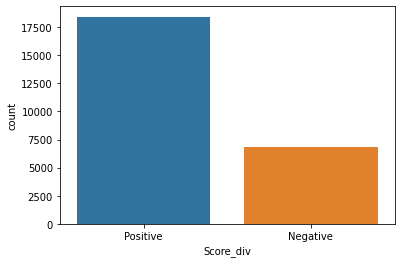

In [130]:
sns.countplot(df_all.Score_div)

### TF-IDF 행렬 생성

In [54]:
# 한 문장으로 join 해놓은 전처리 완료된 문장들을 공백 기준으로 분리하는 함수입니다. 

def my_tokenizer(text):
  return text.split()

In [55]:
# sklearn을 통해서 TF-IDF 행렬을 만들어 줍니다. 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=my_tokenizer, min_df=5, max_df=0.5) # split() 뿐
tfidf_train = tfidf_vect.fit_transform(raw_documents = df_all['preprocessed']) 
tfidf_test = tfidf_vect.transform(raw_documents = df_test['preprocessed']) 


In [56]:
tfidf_train.toarray(), tfidf_test.toarray()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.20380518, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]))

In [57]:
tfidf_train.toarray().shape, tfidf_test.toarray().shape

((25244, 4630), (642, 4630))

In [58]:
print(tfidf_vect.get_feature_names_out())
print(len(tfidf_vect.get_feature_names_out()))

['가게' '가격' '가관' ... '힙지' '힙합' '힙해']
4630


### BoW 행렬 생성

In [59]:
bow_vect = CountVectorizer(tokenizer=my_tokenizer, min_df=10, max_df=0.5, max_features=3000) 
bow_train = bow_vect.fit_transform(raw_documents = df_all['preprocessed']) # 기사 개수는 1000개로 조절하겠습니다
bow_test = bow_vect.transform(raw_documents = df_test['preprocessed']) # 기사 개수는 1000개로 조절하겠습니다

In [60]:
bow_train.toarray().shape, bow_test.toarray().shape

((25244, 2927), (642, 2927))

In [61]:
print(bow_vect.get_feature_names())
print(len(bow_vect.get_feature_names()))

['가게', '가격', '가구', '가기', '가까이', '가깝다', '가끔', '가나', '가능', '가능하다', '가다', '가다가', '가도', '가득', '가득하다', '가든', '가라', '가량', '가로수길', '가루', '가르치다', '가면', '가방', '가볍다', '가보', '가보다', '가성', '가슴', '가시', '가시다', '가요', '가운데', '가을', '가장', '가정', '가져가다', '가져다주다', '가져오다', '가족', '가지', '가지다', '가체', '가치', '각각', '각자', '각종', '간격', '간다', '간단하다', '간만', '간식', '간이', '간판', '갈래', '갈리다', '갈릴', '갈색', '갈수록', '감각', '감동', '감사', '감사하다', '감상', '감성', '감안', '감자', '감탄', '갑자기', '강남', '강남구청역', '강남역', '강력', '강아지', '강요', '강의', '강제', '강조', '강추', '강하다', '갖다', '갖추다', '같다', '개념', '개도', '개맛', '개발', '개방', '개별', '개선', '개성', '개업', '개월', '개인', '개정', '개조', '개존맛', '갤러리', '갯수', '갸또', '거기', '거나', '거리', '거부', '거슬리다', '거의', '거지', '거짓말', '거치다', '거품', '걱정', '건가', '건강', '건강하다', '건너', '건너편', '건대', '건데', '건물', '건지다', '걷다', '걸다', '걸리다', '걸어가다', '검다', '검색', '겁나다', '겁니다', '겉바', '게다가', '게임', '겠다', '겨우', '겨울', '겪다', '견과류', '결과', '결론', '결정', '결제', '경관', '경복궁', '경복궁역', '경우', '경쟁', '경치', '경험', '곁들이다', '계란', '계산', '계속', '계시', '계열', '계절', '고가', '고개', '고객', '고구마

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Train, Test

In [118]:
df_all

,Review,Score,preprocessed,Score_div
0,"딸기뷔페 분위기 좋은 공간, 우드 계열 실내",4,딸기 뷔페 분위기 좋다 공간 우드 계열 실내,2.0
1,망고가 전혀 달지 않아요....다른 호텔 라운지에서도 먹어봤는데 여기만 망고 맛이 ...,2,망고 전혀 않다 다른 호텔 라운지 먹다 보다 망고 작년 괜찮다 같다 매우 아쉽다,1.0
2,호텔이니 비싼거 감안하고 분위기 좋다. 밥도 굳,5,호텔 비싸다 감안 분위기 좋다 굳다,2.0
3,! 물어보니 도쿄와 Spanish차이는 전자 덜 단대요. 갈때 딱 줄이 없었어요. ...,5,물어보다 차이다 전자 단대 줄이다 없다 커피 예쁘다 나오다 라떼 시키다 고소하다,2.0
4,사람 많고 북적거리고 커피도 넘넘 비싸지만맛있고 직원분들도 친절하셔서한 번쯤 가볼만...,5,사람 많다 북적 거리 커피 넘다 넘다 비싸다 맛있다 직원 친절하다 서한 가보다 하다 같다,2.0
...,...,...,...,...
25239,갤러리와 함께 있는 넓은 공간의 카페입니다. illy 커피를 판매하는 곳입니다. 주...,4,갤러리 있다 넓다 공간 카페 커피 판매 하다 주차장 있다,2.0
25240,알바 ○○○ 띠꺼움 ㅋㅋㅋ,1,알바,1.0
25241,교회랑 가까와서 자주 가는데 사장님 음식 맛 짱이고 분위기도 음악도 우리 취향이라 ...,5,교회 가깝다 서다 자주 가다 사장 음식 분위기 음악 우리 취향 넘다 좋다 격주 쉬다...,2.0
25242,한달에 2~3번 가는데요.. 실망한 적이 없네요,5,가다 실망하다 없다,2.0


In [62]:
# Train 
# X_train = tfidf_train
y_train = df_all.Score

# print('#Train set size:', len(X_train))
# X_train

In [63]:
# X_test = tfidf_test
y_test = df_test.Score

# print('#Test set size:', len(X_test))

In [119]:
# #Train, Test 나누기
# tfidf 데이터 분류
X_train, X_test, y_train, y_test = train_test_split(tfidf_train,df_all.Score_div,stratify=df_all.Score_div,train_size=0.85,test_size=0.15,random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(21457, 4630) (3787, 4630) (21457,) (3787,)


## Model

### 모델링 라이브러리

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
import time

## Grid Search 

### GridSearch - LGBM

In [126]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
lgb_model = lgb.LGBMClassifier()

# param_grid 설정
boosted_grid = {'n_estimators': [100, 200, 300],
        'max_depth': [2, 3, 4, 5],
        'learning_rate': [0.2, 0.3, 0.4],
        'boosting_type' : ['gbdt', 'dart','goss','rf']}

# Grid Search 객체 생성
gsLGBM = GridSearchCV(lgb_model, param_grid = boosted_grid, cv=3, scoring="recall_macro", verbose = 1)

# Grid Search 실행
gsLGBM.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
108 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/sklearn.py", line 734, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/sklearn.py", line 538, in fit
    self._Booster = train(params, train_set,
  File "/usr/local/lib/pyt

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                         'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='recall_macro', verbose=1)

In [127]:
# 최적의 파라미터 조합 출력
LGBM_best = gsLGBM.best_params_
print(LGBM_best)

# 최고 점수(accuracy) 출력
print(gsLGBM.best_score_)

{'boosting_type': 'gbdt', 'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 300}
0.7327399751494797


### GridSearch - XGBoost

In [76]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb_model = XGBClassifier(booster = 'gbtree'
)
# param_grid 설정
boosted_grid = {'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.2, 0.3]}

# Grid Search 객체 생성
gsXGB = GridSearchCV(xgb_model, param_grid = boosted_grid, cv=4, scoring="accuracy", verbose = 1)

# Grid Search 실행
gsXGB.fit(X_train, y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


KeyboardInterrupt: ignored

In [ ]:
# 최적의 파라미터 조합 출력
XGB_best = gsXGB.best_estimator_
print(XGB_best)

# 최고 점수(accuracy) 출력
print(gsXGB.best_score_)

## GridSearch - XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb_model = XGBClassifier(booster = 'gbtree'
)
# param_grid 설정
boosted_grid = {'n_estimators': [40, 60, 80, 100, 150],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.2, 0.3]}

# Grid Search 객체 생성
gsXGB = GridSearchCV(xgb_model, param_grid = boosted_grid, cv=4, scoring="accuracy", verbose = 1)

# Grid Search 실행
gsXGB.fit(tfidf_train, y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


KeyboardInterrupt: ignored

In [ ]:
# 최적의 파라미터 조합 출력
XGB_best = gsXGB.best_estimator_
print(XGB_best)

# 최고 점수(accuracy) 출력
print(gsXGB.best_score_)

AttributeError: ignored